         Date       Code    Open    High     Low   Close  Preclose   Volume  \
0  2017-08-14  sh.600519  485.21  500.10  485.21  499.83    484.06  3933147   
1  2017-08-15  sh.600519  500.11  501.10  495.01  495.97    499.83  2716322   
2  2017-08-16  sh.600519  498.00  498.80  493.00  496.49    495.97  1858722   
3  2017-08-17  sh.600519  497.60  497.60  489.80  492.69    496.49  2584673   
4  2017-08-18  sh.600519  492.80  494.44  488.00  489.65    492.69  2385775   

         Amount  Adjustflag      Turn  Tradestatus    Pctchg      Pettm  \
0  1.952354e+09           3  0.313099            1  3.257858  32.759372   
1  1.350105e+09           3  0.216234            1 -0.772260  32.506384   
2  9.214130e+08           3  0.147964            1  0.104843  32.540465   
3  1.272341e+09           3  0.205754            1 -0.765370  32.291409   
4  1.169733e+09           3  0.189920            1 -0.617023  32.092165   

      Pbmrq      Psttm  Pcfncfttm  
0  8.302876  13.384504  25.786295  
1 

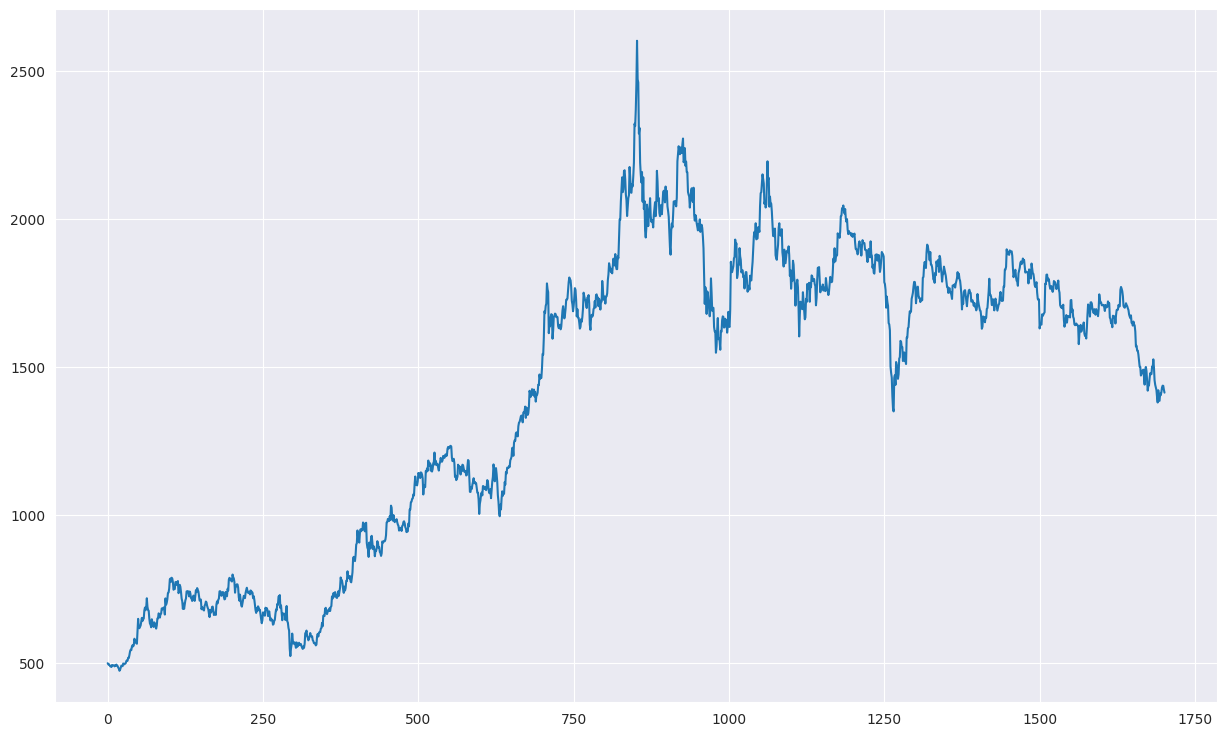

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

filepath = '../../data/600519.csv'
data = pd.read_csv(filepath)
data = data.sort_values('Date')
print(data.head())
print(data.shape)

sns.set_style("darkgrid")
plt.figure(figsize=(15, 9))
plt.plot(data[['Close']])
plt.show()

## 1.特征工程

In [47]:
# 选取Close作为特征
price = data[['Close']]
# 选曲后20%的数据
# split = int(0.2 * len(price))
# price= price[-split:]
# print(price.info())

from sklearn.preprocessing import MinMaxScaler
# 进行不同的数据缩放，将数据缩放到-1和1之间
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1, 1))
print(price['Close'].shape)

(1702,)


/tmp/ipykernel_697251/2632869585.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



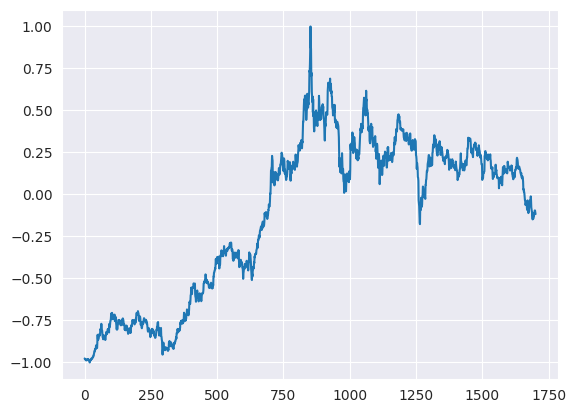

In [48]:
plt.plot(price['Close'])

## 2.数据集制作

In [49]:
# 今天的收盘价预测明天的收盘价
# lookback表示观察的跨度
# def split_data(stock, lookback):
#     data_raw = stock.to_numpy()
#     data = []
#     # print(data)

#     # you can free play（seq_length）
#     for index in range(len(data_raw) - lookback):
#         data.append(data_raw[index: index + lookback])

#     data = np.array(data)
#     test_set_size = int(np.round(0.2 * data.shape[0]))
#     train_set_size = data.shape[0] - (test_set_size)

#     x_train = data[:train_set_size, :-1, :]
#     y_train = data[:train_set_size, -1, :]

#     x_test = data[train_set_size:, :-1]
#     y_test = data[train_set_size:, -1, :]

#     return [x_train, y_train, x_test, y_test]


# lookback = 20
# X_train, y_train, x_test, y_test = split_data(price, lookback)
# print('x_train.shape = ', x_train.shape)
# print('y_train.shape = ', y_train.shape)
# print('x_test.shape = ', x_test.shape)
# print('y_test.shape = ', y_test.shape)



def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

from sklearn.model_selection import train_test_split

lookback=10

X, y = create_sequences(price[['Close']].values, lookback)
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.1,shuffle=False,random_state=42)

# 去除最后一个为1的维度,并且转换为float32 tensor

def format_data(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    X_train=torch.from_numpy(np.squeeze(X_train, axis=2)).to(torch.float32).unsqueeze(0)
    X_test=torch.from_numpy(np.squeeze(X_test, axis=2)).to(torch.float32).unsqueeze(0)
    y_train=torch.from_numpy(np.squeeze(y_train, axis=1)).to(torch.float32)
    y_test=torch.from_numpy(np.squeeze(y_test, axis=1)).to(torch.float32)
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test=format_data()
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([1, 1522, 10]),
 torch.Size([1, 170, 10]),
 torch.Size([1522]),
 torch.Size([170]))

In [50]:
# shuffle training dataset
# indices = np.random.permutation(len(X_train))
# X_train = X_train[indices]
# y_train = y_train[indices]

## 3.模型构建 —— Mamba

In [51]:
# 注意：pytorch的nn.LSTM input shape=(seq_length, batch_size, input_size)
# 3.模型构建 —— Mamba

import torch
import torch.nn as nn
import torch.nn.functional as F
from mamba import Mamba, MambaConfig

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

y_train_mamba = y_train
y_test_mamba = y_test
# 输入的维度为1，只有Close收盘价
input_dim = 1
# 隐藏层特征的维度
hidden_dim = 15
# 循环的layers
num_layers = 2
# 预测后一天的收盘价
output_dim = 1
num_epochs = 300



class Net(nn.Module):
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.config = MambaConfig(d_model=hidden_dim, n_layers=num_layers)
        self.mamba = nn.Sequential(
            nn.Linear(in_dim,hidden_dim),
            Mamba(self.config),
            nn.Linear(hidden_dim,out_dim),
            nn.Tanh()
        )

    def forward(self,x):
        x = self.mamba(x)
        return x.flatten()


X_train=X_train.to(device)
y_train_mamba=y_train_mamba.to(device)
model = Net(X_train.shape[2],output_dim)
model=model.to(device)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01,weight_decay=0.0001)

## 4.模型训练

In [52]:
X_train.shape

torch.Size([1, 1522, 10])

In [53]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

model.train()

for t in range(num_epochs):
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train_mamba)
    if(t % 10 == 0):
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.18452391028404236
Epoch  10 MSE:  0.010991498827934265
Epoch  20 MSE:  0.007097467314451933
Epoch  30 MSE:  0.005347812548279762
Epoch  40 MSE:  0.003883049124851823
Epoch  50 MSE:  0.003547822590917349
Epoch  60 MSE:  0.003033023327589035
Epoch  70 MSE:  0.0026951725594699383
Epoch  80 MSE:  0.0024197944439947605
Epoch  90 MSE:  0.0021875263191759586
Epoch  100 MSE:  0.002001814777031541
Epoch  110 MSE:  0.001840552082285285
Epoch  120 MSE:  0.0016990837175399065
Epoch  130 MSE:  0.0015787144657224417
Epoch  140 MSE:  0.0014783923979848623
Epoch  150 MSE:  0.0013913133880123496
Epoch  160 MSE:  0.0013086525723338127
Epoch  170 MSE:  0.0013079006457701325
Epoch  180 MSE:  0.0013311285292729735
Epoch  190 MSE:  0.0011621771845966578
Epoch  200 MSE:  0.0011003257241100073
Epoch  210 MSE:  0.0010772017994895577
Epoch  220 MSE:  0.0010493180016055703
Epoch  230 MSE:  0.0010025185765698552
Epoch  240 MSE:  0.001020322903059423
Epoch  250 MSE:  0.0012239643838256598
Epoch  2

## 5.模型结果可视化

In [54]:
X=torch.from_numpy(X).to(torch.float32).to(device).squeeze(-1).unsqueeze(0)
X.shape

torch.Size([1, 1692, 10])

In [55]:
price=price.to_numpy().squeeze()
X.shape,price.shape

(torch.Size([1, 1692, 10]), (1702,))

In [56]:
X_test.shape

torch.Size([1, 170, 10])

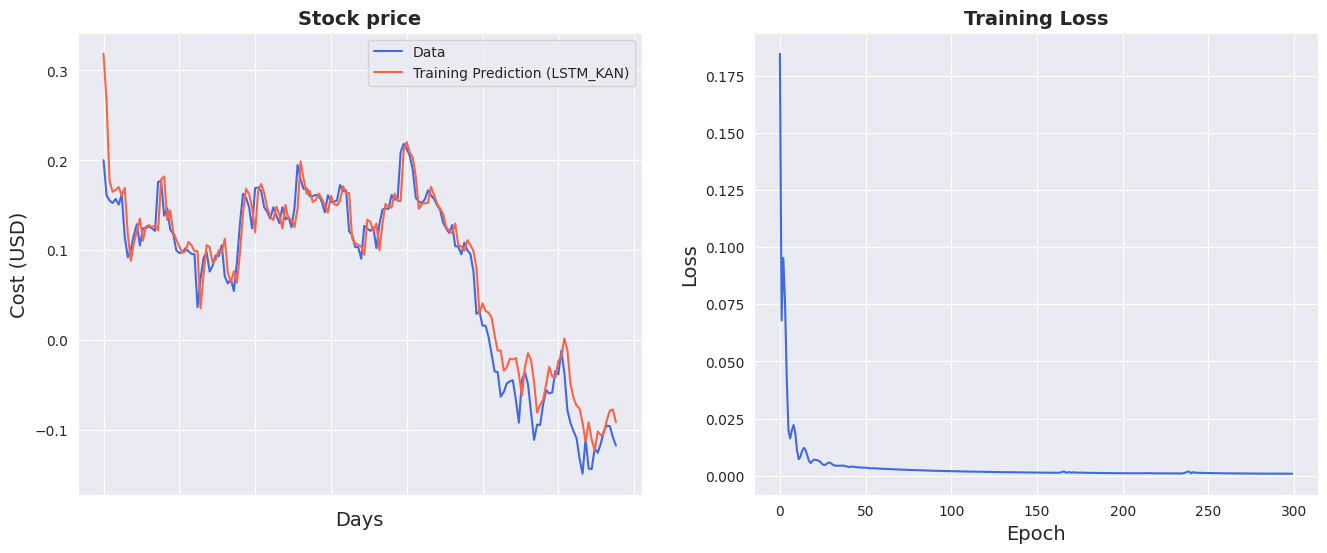

In [57]:
predict = pd.DataFrame(model(X_test.to(device)).cpu().detach())
original = pd.DataFrame(y_test)


import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM_KAN)", color='tomato')
# print(predict.index)
# print(predict[0])


ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

## 6.模型验证

In [58]:
# print(x_test[-1])
import math, time
from sklearn.metrics import mean_squared_error,r2_score

# make predictions
y_test_pred = model(X_test.to(device)).cpu().detach().numpy()

# invert predictions
if type(y_train_pred) is not np.ndarray:
    y_train_pred = y_train_pred.detach().cpu().numpy()
if type(y_test_pred) is not np.ndarray:
    y_test_pred = y_test_pred.detach().cpu().numpy()
if type(y_train) is not np.ndarray:
    y_train=y_train.detach().cpu().numpy()
if type(y_test) is not np.ndarray:
    y_test=y_test.detach().cpu().numpy()

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, y_test_pred))
print('Test Score: %.2f RMSE' % (testScore))


trainr2Score = r2_score(y_train, y_train_pred)
print('Train Score: %.2f R2' % (trainr2Score))
testr2Score = r2_score(y_test, y_test_pred)
print('Test Score: %.2f R2' % (testr2Score))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[ :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1] = y_test_pred

original = price

predictions = np.append(trainPredictPlot, testPredictPlot, axis=0)
predictions = np.append(predictions, original, axis=0)
result = pd.DataFrame(predictions)

Train Score: 0.03 RMSE
Test Score: 0.03 RMSE
Train Score: 1.00 R2
Test Score: 0.93 R2


## 7. 绘制图像

In [59]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

KeyError: 1